# NB! Clone the following repo before running this Notebook :)

In [ ]:
!git clone https://github.com/y0ast/DUE.git

In [1]:
import numpy as np
import sklearn.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from ignite.engine import Events, Engine
from ignite.metrics import Average, Loss
from ignite.contrib.handlers import ProgressBar

import gpytorch
from gpytorch.mlls import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood

from due.dkl import DKL, GP, initial_values
from due.sngp import Laplace
from due.fc_resnet import FCResNet

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

torch.set_default_dtype(torch.float32)

plt.rcParams['figure.dpi'] = 140
DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

### Use GPU if available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


### Generating Two Moons / Circles Dataset

In [3]:
# Two Moons
def make_moon_training_data(sample_size=500):
    
    """Create two moon training dataset."""
    train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

    # Adjust data position slightly.
    train_examples[train_labels == 0] += [-0.1, 0.2]
    train_examples[train_labels == 1] += [0.1, -0.2]

    return train_examples, train_labels

def make_moon_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)
    return np.stack([xv.flatten(), yv.flatten()], axis=-1)

def make_moon_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size)

# Two Circles
def make_circles_training_data(sample_size=500):
    
    """Create two circles training dataset."""
    train_examples, train_labels = sklearn.datasets.make_circles(
      n_samples=2 * sample_size, noise=0.1)

    # Adjust data position slightly.
    train_examples[train_labels == 0] += [-1.2, - 0.7]
    train_examples[train_labels == 1] += [1.15, - 0.7]

    return train_examples, train_labels

def make_circles_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)
    return np.stack([xv.flatten(), yv.flatten()], axis=-1)

def make_circles_ood_data(sample_size=500, means=(-0.3, 1.36), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size)

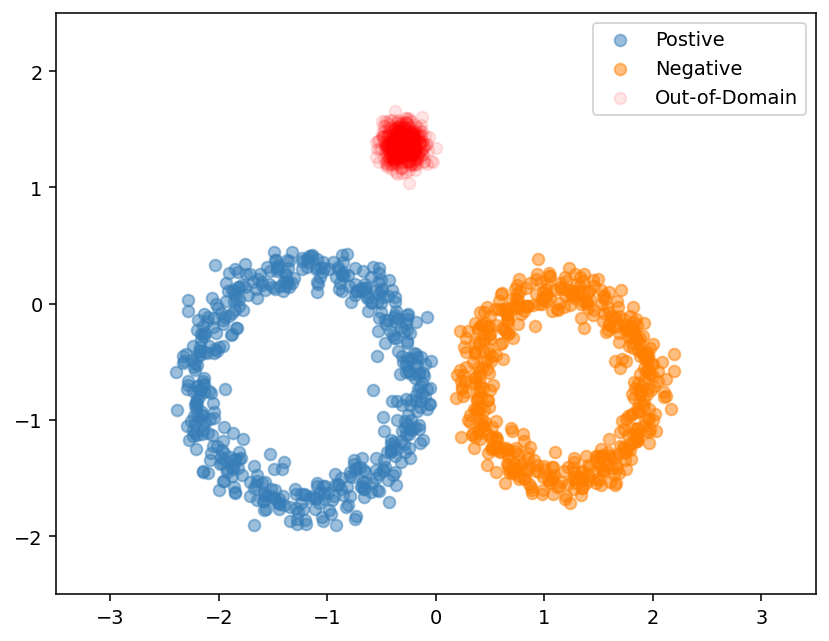

In [4]:
# Use false for Circles dataset
moon_dataset = False

# Load the Train, Test and OOD Dataset
if moon_dataset:
    train_examples, train_labels = make_moon_training_data(sample_size=500)
    test_examples = make_moon_testing_data()
    ood_examples = make_moon_ood_data(sample_size=500)
else:
    train_examples, train_labels = make_circles_training_data(sample_size=500)
    test_examples = make_circles_testing_data()
    ood_examples = make_circles_ood_data(sample_size=500)
    
# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Postive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

### Batched Dataset Loader

In [5]:
ds_train = torch.utils.data.TensorDataset(torch.from_numpy(train_examples).float(), torch.from_numpy(train_labels).long())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True, drop_last=True)

In [6]:
# Sanity Check
for batch_num, (datas) in enumerate(dl_train):
    X, y = datas
    print(X.shape, y.shape, X.dtype, y.dtype)
    
    break

torch.Size([128, 2]) torch.Size([128]) torch.float32 torch.int64


### Training Loop

In [7]:
steps = 5e3
epochs = 25

# Change this boolean to False for SNGP
DUE = False

input_dim = 2
features = 128
depth = 6
num_outputs = 2 
spectral_normalization = True
coeff = 0.95
n_power_iterations = 1
dropout_rate = 0.01

feature_extractor = FCResNet(
    input_dim=input_dim, 
    features=features, 
    depth=depth, 
    spectral_normalization=spectral_normalization, 
    coeff=coeff, 
    n_power_iterations=n_power_iterations,
    dropout_rate=dropout_rate
)

if DUE:
    n_inducing_points = 20
    kernel = "RBF"
    
    initial_inducing_points, initial_lengthscale = initial_values(
            ds_train, feature_extractor, n_inducing_points
    )

    gp = GP(
        num_outputs=num_outputs,
        initial_lengthscale=initial_lengthscale,
        initial_inducing_points=initial_inducing_points,
        kernel=kernel,
    )

    model = DKL(feature_extractor, gp)

    likelihood = GaussianLikelihood()
    elbo_fn = VariationalELBO(likelihood, model.gp, num_data=len(ds_train))
    loss_fn = lambda x, y: -elbo_fn(x, y)
else:
    num_gp_features = 256
    num_random_features = 1024
    normalize_gp_features = True
    feature_scale = 2
    ridge_penalty = 1
    
    model = Laplace(feature_extractor,
                    features,
                    num_gp_features,
                    normalize_gp_features,
                    num_random_features,
                    num_outputs,
                    len(ds_train),
                    128,
                    ridge_penalty=ridge_penalty,
                    feature_scale=feature_scale,
                    mean_field_factor=2
                   )

    loss_fn = F.cross_entropy

if torch.cuda.is_available():
    model = model.cuda()
    if DUE:
        likelihood = likelihood.cuda()
    
lr = 1e-3

parameters = [
    {"params": model.parameters(), "lr": lr},
]

if DUE:
    parameters.append({"params": likelihood.parameters(), "lr": lr})
    
    
optimizer = torch.optim.Adam(parameters)
pbar = ProgressBar()

def step(engine, batch):
    model.train()
    if DUE:
        likelihood.train()
    
    optimizer.zero_grad()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x)
    
    if not DUE:
        y_pred.squeeze_()

    loss = loss_fn(y_pred, y)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

    
trainer = Engine(step)
# evaluator = Engine(eval_step)

metric = Average()
metric.attach(trainer, "loss")
pbar.attach(trainer)

if DUE:
    metric = Loss(lambda y_pred, y: - likelihood.expected_log_prob(y, y_pred).mean())
else:
    metric = Loss(lambda y_pred, y: F.mse_loss(y_pred[0].squeeze(), y))


# metric.attach(evaluator, "loss")

@trainer.on(Events.EPOCH_COMPLETED(every=int(epochs/10) + 1))
def log_results(trainer):
    # evaluator.run(dl_test)
    print(f"Results - Epoch: {trainer.state.epoch} - "
          # f"Test Likelihood: {evaluator.state.metrics['loss']:.2f} - "
          f"Loss: {trainer.state.metrics['loss']:.2f}")

    
if not DUE:
    @trainer.on(Events.EPOCH_STARTED)
    def reset_precision_matrix(trainer):
        model.reset_precision_matrix()

In [8]:
trainer.run(dl_train, max_epochs=epochs)

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

Results - Epoch: 3 - Loss: 0.17


[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

Results - Epoch: 6 - Loss: 0.05


[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

Results - Epoch: 9 - Loss: 0.02


[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

Results - Epoch: 12 - Loss: 0.02


[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

Results - Epoch: 15 - Loss: 0.01


[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

Results - Epoch: 18 - Loss: 0.01


[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

Results - Epoch: 21 - Loss: 0.02


[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

[1/7]  14%|#4         [00:00<?]

Results - Epoch: 24 - Loss: 0.01


[1/7]  14%|#4         [00:00<?]

State:
	iteration: 175
	epoch: 25
	epoch_length: 7
	max_epochs: 25
	output: 0.004144923761487007
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

### Inference on OOD inputs

In [9]:
test_examples = test_examples.astype(np.float32)
test_examples = torch.from_numpy(test_examples).to(device)

In [10]:
# SNGP Model

softmax = nn.Softmax(dim=-1)
model.eval()

with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
    model_logits = model(test_examples)
    model_probs = softmax(model_logits)[:, 0]
    model_uncertainty = model_probs * (1 - model_probs)

### Visualizing Uncertainty Surface

In [11]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
    """Visualizes the 2D uncertainty surface.

    For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).

    Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the 
      predictive surface.

    Returns:
    pcm: A matplotlib PathCollection object that contains the palette 
      information of the uncertainty plot.
    """
    # Normalize uncertainty for better visualization.
    test_uncertainty = test_uncertainty / np.max(test_uncertainty)

    # Set view limits.
    ax.set_ylim(DEFAULT_Y_RANGE)
    ax.set_xlim(DEFAULT_X_RANGE)

    # Plot normalized uncertainty surface.
    pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]), 
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic', 
      aspect='auto')

    # Plot training data.
    ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
    ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

    return pcm

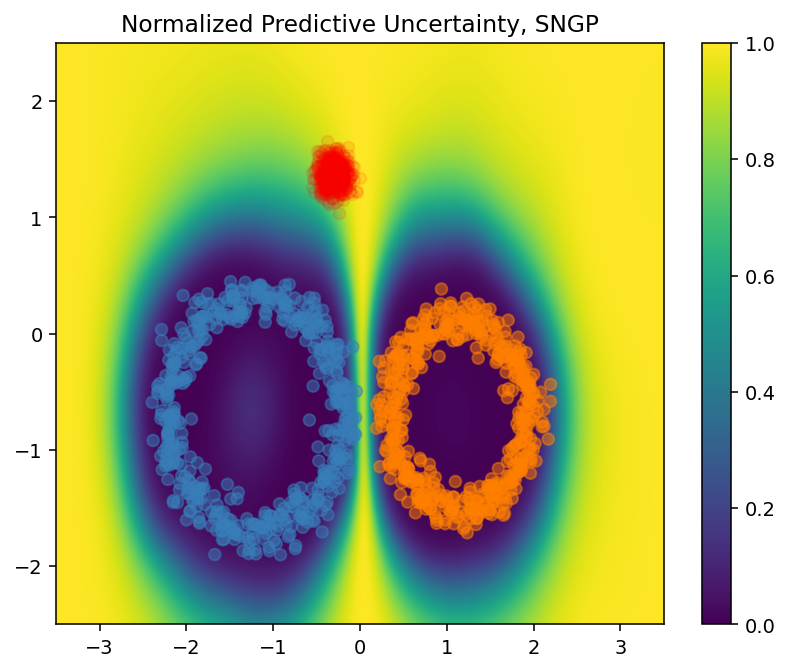

In [12]:
_, ax = plt.subplots(figsize=(7, 5.5))
pcm = plot_uncertainty_surface(model_uncertainty.cpu().numpy(), ax=ax)
plt.colorbar(pcm, ax=ax)
plt.title("Normalized Predictive Uncertainty, SNGP")
plt.show()